#  Seminar on Dinmensionality Reduction
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook
## March 17th, 2021


## Background
The spread of diseases by the vector, mosquito, is a major topic in epidemiology. Mosquitoes are known to transmit malaria, the West Nile virus, chikungunya, the Zika virus, and dengue fever among other diseases. Mosquitoes of the genus *Aedes* have populated the globe due to trade, and the two species *Aedes aegypti* and *Aedes albopictus* are known to be carriers of the Zika virus and dengue fever. In particular, these species are known to be prevalent throughout the southern United States, and efforts to control their populations have been attempted.

A study by Myer et al. (2019) considered several ecological, socioeconomical, and meteorological factors in the understanding of how both species of mosquitoes thrive in Brownsville, TX. This study provided a data set on the number of mosquitoes trapped for both species at particular locations of Brownsville. To further explore other potential models for the population dynamics of both these species, regressors were considered in the mapping of these populations based on only the ecological and meteorological variables given from this study. 


## Data Processing and Exploration

In [ ]:
! pip install --upgrade numpy
! pip install --upgrade pandas

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.4)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.5)


In [ ]:
import numpy as np
import pandas as pd
import requests
import io
from copy import deepcopy  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 25)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Find the BrownsvilleData_SciHub.csv file in the Files menu on the left
# Right click the file and click Copy Path
# Paste the path between the quotation marks below
path = "/content/drive/MyDrive/Data_ScienceF20_Final/BrownsvilleData_SciHub.csv"
df = pd.read_csv(path)

names = ['ID', 'TrapNumber',
         'y_aeg','y_albo',
         'Lat','Long','Date',
         'isoweek','Total',
         'Proportion_Water_10','Proportion_Impervious_20','Proportion_Soil_30','Proportion_Tree_40',
         'Proportion_Shrub_52','Proportion_Grass_70','Proportion_WW_91','Proportion_EW_92',
         'VegHi','MedianValue','AvgPopDens',
         'Prop_2010_newer','Prop_2000_2009','Prop_1990_1999',
         'Prop_1980_1989','Prop_1970_1979','Prop_1960_1969',
         'Prop_1950_1959','Prop_1940_1949','Prop_1939_older',
         'ordweek','Prcp','Tmax','Tmin','Rad','VPres','L1Prcp','L1Tmax','L1Tmin',
         'L1Rad','L1VPres','L2Prcp','L2Tmax','L2Tmin','L2Rad','L2Vpres','Prop_1949_older',
         'Prop_1959_older','Prop_1969_older','Prop_1979_older',
         'Prop_1989_older','Prop_1999_older','Prop_2009_older','Temp','L1Temp','L2Temp']
df.columns = names
total_mos = df['y_aeg'] + df['y_albo']
df.insert(4, 'Total_mos', total_mos, True)
org_df = df.copy()

dropped = ['ID', 'TrapNumber','Lat','Long','Date',
        'isoweek','Total','MedianValue','Prop_2010_newer','Prop_2000_2009','Prop_1990_1999',
        'Prop_1980_1989','Prop_1970_1979','Prop_1960_1969',
        'Prop_1950_1959','Prop_1940_1949','Prop_1939_older',
        'ordweek','Tmax','Tmin','L1Tmax','L1Tmin','L2Tmax','L2Tmin',
         'Prop_1949_older','Prop_1959_older','Prop_1969_older','Prop_1979_older',
        'Prop_1989_older','Prop_1999_older','Prop_2009_older']
df = df.drop(columns=dropped, axis = 1)

df_mos = df.drop(columns=['Total_mos'])
df_total = df.drop(columns=['y_aeg', 'y_albo'])


### Dataset
The data set given has 5367 data points with a total of 53 variables. Of those variables, the ones of interest for predicting the number of both species individually and collectively were the types of land cover and the various weather-related variables such as precipitation, humidity, and average temperature. In addition to these, the weather-related variables 1 week and 2 weeks prior to the counting of the mosquito species were included since past weather patterns play an essential role in mosquito reproduction. As a result, only 25 variables were considered in the making of the models. Since there were no missing values in the data set, no imputations were required.

In [ ]:
df.describe()

,y_aeg,y_albo,Total_mos,Proportion_Water_10,Proportion_Impervious_20,Proportion_Soil_30,Proportion_Tree_40,Proportion_Shrub_52,Proportion_Grass_70,Proportion_WW_91,Proportion_EW_92,VegHi,AvgPopDens,Prcp,Rad,VPres,L1Prcp,L1Rad,L1VPres,L2Prcp,L2Rad,L2Vpres,Temp,L1Temp,L2Temp
count,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000,5367.000000
mean,6.592137,0.403764,6.995901,0.015072,0.459296,0.018597,0.209173,0.034489,0.261042,0.000832,0.001498,1.677682,2.260471,1.619207,366.682232,2262.851800,1.811414,366.098688,2262.961476,1.927201,366.363672,2291.061233,26.146317,26.018386,26.192945
std,10.907227,1.606108,11.124611,0.043928,0.211937,0.035180,0.124459,0.037821,0.147224,0.005354,0.011283,0.886148,1.603849,2.931897,66.803638,709.875279,3.181764,62.896498,721.958687,3.260813,65.502988,739.241361,3.318782,3.542588,3.517270
min,0.000000,0.000000,0.000000,0.000000,0.022275,0.000000,0.006662,0.000924,0.011189,0.000000,0.000000,0.153799,0.000000,0.000000,240.000000,931.428600,0.000000,240.914282,931.428600,0.000000,240.914282,931.428600,18.250000,18.250000,16.892857
25%,1.000000,0.000000,1.000000,0.000000,0.355609,0.000000,0.100682,0.014950,0.175351,0.000000,0.000000,1.149054,1.123215,0.000000,306.742900,1657.143000,0.000000,306.285700,1622.857000,0.000000,304.000000,1622.857000,23.571430,23.464286,24.142857
50%,3.000000,0.000000,3.000000,0.000000,0.442641,0.005798,0.210531,0.024347,0.232824,0.000000,0.000000,1.609778,2.171531,0.285714,376.228600,2217.143000,0.428571,375.314300,2217.143000,0.428571,378.057100,2234.286000,26.107140,26.178570,26.821430
75%,8.000000,0.000000,8.000000,0.001435,0.577111,0.020244,0.282278,0.038069,0.317366,0.000000,0.000000,2.186665,3.421663,1.714286,409.600000,2931.428571,2.000000,406.857138,2960.000000,2.428571,408.228600,3017.143000,29.285714,29.285710,29.321430
max,135.000000,27.000000,135.000000,0.298961,0.958465,0.185877,0.507728,0.252134,0.719273,0.052033,0.118604,4.283593,6.584843,16.142860,528.457100,3440.000000,16.571430,528.000000,3440.000000,16.571430,528.000000,3440.000000,31.142860,31.142860,31.142860


Each model considered one of the three target variables: the number of Aedes aegypti mosquitoes caught, the number of Aedes albopictus mosquitoes caught, and the number of both species of mosquitos caught. Each model applied the same feature variables in their creation. The dataset for each model was split into modeling and holdouts sets in which 80% of the data was allocated into the modeling set and 20% of the data was allocated into the holdout set using a shuffle split algorithm. 

In [ ]:
#Modelling datasets for the Aedes aegypti species
X_aeg = df_mos.drop(columns=['y_aeg', 'y_albo'])
y_aeg = df_mos['y_aeg']

holdout_frac = 0.20
holdout_splitter = ShuffleSplit(n_splits=5, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_aeg, y_aeg))
X_aeg_m, y_aeg_m = X_aeg.iloc[model_idx]  , y_aeg.iloc[model_idx]
X_aeg_h, y_aeg_h = X_aeg.iloc[holdout_idx], y_aeg.iloc[holdout_idx]

#Modelling datasets for the Aedes albopictus species
X_alb = df_mos.drop(columns=['y_aeg', 'y_albo'])
y_alb = df_mos['y_albo']

holdout_frac = 0.20
holdout_splitter = ShuffleSplit(n_splits=5, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_alb, y_alb))
X_alb_m, y_alb_m = X_alb.iloc[model_idx]  , y_alb.iloc[model_idx]
X_alb_h, y_alb_h = X_alb.iloc[holdout_idx], y_alb.iloc[holdout_idx]

#Modelling datasets for the both species
X_tot = df_total.drop(columns=['Total_mos'])
y_tot = df_total['Total_mos']

holdout_frac = 0.20
holdout_splitter = ShuffleSplit(n_splits=5, test_size=holdout_frac, random_state=42)
model_idx, holdout_idx = next(holdout_splitter.split(X_tot, y_tot))
X_tot_m, y_tot_m = X_tot.iloc[model_idx]  , y_tot.iloc[model_idx]
X_tot_h, y_tot_h = X_tot.iloc[holdout_idx], y_tot.iloc[holdout_idx]

## Supervised Model Building and Selection

The regressors for the mosquito counts were the K-Nearest Neighbors regressor, the Random Forest regressor, and the Lasso regressor. For all models, three different scalers were used to transform the data. Those being the standard scaler, the min-max scaler, and the robust scalers. In addition, Principal Components Analysis were applied to each model to determine if lowering the dimension of the model improved the regressor's predictability. The number of dimensions considered were multiples of 5 up until the dimension of the original data set. 
 
For the K-Nearest Neighbor regressor, the hyperparameters of interest were the number of neighbors and the weight function used for the prediction. The number of neighbors chosen were multiples of 5 up until 25 and the weight functions considered were the uniform and distance weight functions. 

For the Random Forest regressor, the hyperparameter of interest was the maximum depth of each decision tree. The maximum depth of each decision tree were multiples of 2 up until 10.

For the Lasso regressor, the hyperparameter of interest was the coefficient penalty, alpha. Alpha was given by 9 equally spaced points from 0.2 to 2.

For each model, k-fold cross validation was performed using the R squared score as a performance metric.

In [ ]:
def top_knr(X_m, y_m):
    scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
    grid_k = {}
    for s in scaler_type:
        pipe = Pipeline([('scale', s()),
                        ('dim_reduce', PCA()),
                        ('classify'  , KNeighborsRegressor())
                        ])

        hyperparams = {
                    'dim_reduce__n_components' : np.concatenate((np.arange(1,2), np.arange(5,21,5), np.arange(22,23)), axis = None),
                    'classify__n_neighbors' : np.concatenate((np.arange(1,2), np.arange(5,26,5)), axis = None),
                    'classify__weights' : ['uniform', 'distance']
                    }
        grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(X_m, y_m)
    res1 = grid_k["grid_StandardScaler"].cv_results_
    df1 = pd.DataFrame(res1['params'])
    df1['score'] = res1['mean_test_score']
    df1['scale'] = 'standard'

    res2 = grid_k["grid_MinMaxScaler"].cv_results_
    df2 = pd.DataFrame(res2['params'])
    df2['score'] = res2['mean_test_score']
    df2['scale'] = 'min_max'

    res3 = grid_k["grid_RobustScaler"].cv_results_
    df3 = pd.DataFrame(res3['params'])
    df3['score'] = res3['mean_test_score']
    df3['scale'] = 'robust'

    res = [df1, df2, df3]
    df = pd.concat(res, ignore_index = True)
    M = df['score'].quantile(q = 0.95)
    mask = df['score'] > M
    return df[mask].sort_values(by = 'score', ascending = False)

In [ ]:
def top_rfr(X_m, y_m):
    scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
    grid_k = {}
    for s in scaler_type:
        pipe = Pipeline([('scale', s()),
                        ('dim_reduce', PCA()),
                        ('classify' , RandomForestRegressor(random_state=42))
                        ])

        hyperparams = {
                    'dim_reduce__n_components' : np.concatenate((np.arange(1,2), np.arange(5,21,5), np.arange(22,23)), axis = None),
                    'classify__max_depth' : np.arange(2, 11, 2)
                    }
        grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(X_m, y_m)
    res1 = grid_k["grid_StandardScaler"].cv_results_
    df1 = pd.DataFrame(res1['params'])
    df1['score'] = res1['mean_test_score']
    df1['scale'] = 'standard'

    res2 = grid_k["grid_MinMaxScaler"].cv_results_
    df2 = pd.DataFrame(res2['params'])
    df2['score'] = res2['mean_test_score']
    df2['scale'] = 'min_max'


    res3 = grid_k["grid_RobustScaler"].cv_results_
    df3 = pd.DataFrame(res3['params'])
    df3['score'] = res3['mean_test_score']
    df3['scale'] = 'robust'

    res = [df1, df2, df3]
    df = pd.concat(res, ignore_index = True)

    M = df['score'].quantile(q = 0.95)
    mask = df['score'] > M
    return df[mask].sort_values(by = 'score', ascending = False)

In [ ]:
def top_las(X_m, y_m):
    scaler_type = [StandardScaler, MinMaxScaler, RobustScaler]
    grid_k = {}
    for s in scaler_type:
        pipe = Pipeline([('scale', s()),
                        ('dim_reduce', PCA()),
                        ('classify'  , Lasso(normalize=False, random_state=42))
                        ])

        hyperparams = {
                    'dim_reduce__n_components' : np.concatenate((np.arange(1,2), np.arange(5,21,5), np.arange(22,23)), axis = None),
                    'classify__alpha' : np.linspace(0.2, 2, 9)
                    }
        grid_k["grid_" + s.__name__] = GridSearchCV(pipe, hyperparams, cv=10, scoring='r2').fit(X_m, y_m)
    res1 = grid_k["grid_StandardScaler"].cv_results_
    df1 = pd.DataFrame(res1['params'])
    df1['score'] = res1['mean_test_score']
    df1['scale'] = 'standard'

    res2 = grid_k["grid_MinMaxScaler"].cv_results_
    df2 = pd.DataFrame(res2['params'])
    df2['score'] = res2['mean_test_score']
    df2['scale'] = 'min_max'

    res3 = grid_k["grid_RobustScaler"].cv_results_
    df3 = pd.DataFrame(res3['params'])
    df3['score'] = res3['mean_test_score']
    df3['scale'] = 'robust'

    res = [df1, df2, df3]
    df = pd.concat(res, ignore_index = True)
    M = df['score'].quantile(q = 0.95)
    mask = df['score'] > M
    return df[mask].sort_values(by = 'score', ascending = False)

In [ ]:
#All models for Aedes aegypti species
aeg_knr = top_knr(X_aeg_m, y_aeg_m)
aeg_knr['model'] = 'knr'
aeg_knr['species'] = 'aeg'
aeg_rfr = top_rfr(X_aeg_m, y_aeg_m)
aeg_rfr['model'] = 'rfr'
aeg_rfr['species'] = 'aeg'
aeg_las = top_las(X_aeg_m, y_aeg_m)
aeg_las['model'] = 'las'
aeg_las['species'] = 'aeg'


#Best models for Aedes aegypti species
M1 = aeg_knr['score'].max()
M2 = aeg_rfr['score'].max()
M3 = aeg_las['score'].max()
mask1 = aeg_knr['score'] == M1
mask2 = aeg_rfr['score'] == M2
mask3 = aeg_las['score'] == M3


aeg_model = [aeg_knr[mask1], aeg_rfr[mask2], aeg_las[mask3]]
aeg_scores = [aeg_knr[mask1]['score'].iloc[0], aeg_rfr[mask2]['score'].iloc[0], aeg_las[mask3]['score'].iloc[0]]
aeg_model_best = aeg_model[np.argmax(aeg_scores)]

In [ ]:
aeg_model_best

,classify__max_depth,dim_reduce__n_components,score,scale,model,species
0,10,15,0.388783,robust,rfr,aeg


In [ ]:
#All models for Aedes albopictus species
alb_knr = top_knr(X_alb_m, y_alb_m)
alb_knr['model'] = 'knr'
alb_knr['species'] = 'alb'
alb_rfr = top_rfr(X_alb_m, y_alb_m)
alb_rfr['model'] = 'rfr'
alb_rfr['species'] = 'alb'
alb_las = top_las(X_alb_m, y_alb_m)
alb_las['model'] = 'las'
alb_las['species'] = 'alb'

#Best models for Aedes albopictus species
M1 = alb_knr['score'].max()
M2 = alb_rfr['score'].max()
M3 = alb_las['score'].max()
mask1 = alb_knr['score'] == M1
mask2 = alb_rfr['score'] == M2
mask3 = alb_las['score'] == M3

alb_model = [alb_knr[mask1], alb_rfr[mask2], alb_las[mask3]]
alb_scores = [alb_knr[mask1]['score'].iloc[0], alb_rfr[mask2]['score'].iloc[0], alb_las[mask3]['score'].iloc[0]]
alb_model_best = alb_model[np.argmax(alb_scores)]

In [ ]:
alb_model_best

,classify__n_neighbors,classify__weights,dim_reduce__n_components,score,scale,model,species
0,15,uniform,10,0.277847,standard,knr,alb


In [ ]:
#All models for both species
tot_knr = top_knr(X_tot_m, y_tot_m)
tot_knr['model'] = 'knr'
tot_knr['species'] = 'tot'
tot_rfr = top_rfr(X_tot_m, y_tot_m)
tot_rfr['model'] = 'rfr'
tot_rfr['species'] = 'tot'
tot_las = top_las(X_tot_m, y_tot_m)
tot_las['model'] = 'las'
tot_las['species'] = 'tot'

#Best models for both species
M1 = tot_knr['score'].max()
M2 = tot_rfr['score'].max()
M3 = tot_las['score'].max()
mask1 = tot_knr['score'] == M1
mask2 = tot_rfr['score'] == M2
mask3 = tot_las['score'] == M3

tot_model = [tot_knr[mask1], tot_rfr[mask2], tot_las[mask3]]
tot_scores = [tot_knr[mask1]['score'].iloc[0], tot_rfr[mask2]['score'].iloc[0], tot_las[mask3]['score'].iloc[0]]
tot_model_best = tot_model[np.argmax(tot_scores)]

In [ ]:
tot_model_best

,classify__max_depth,dim_reduce__n_components,score,scale,model,species
0,10,15,0.380785,standard,rfr,tot


Result Summary: 
- The best model for the count of the *Aedes aegypti* species was the Random Forest regressor which applied a max depth of 10 for the decision trees and in which the data was scaled by the robust scaler and the data was reduced to 10 dimensions. 

- The best model for the count of the *Aedes albopictus* species was the K-Nearest Neighbor regressor which applied the uniform weight function and 15 neighbors and in which the data was scaled by the standard scaler and the data was reduced to 15 dimensions.

- The best model for the count of both species was the Random Forest regressor which applied a max depth of 10 for the decision trees and in which the data was scaled by the standard scaler and the data was reduced to 10 dimensions. 

## Model Performance

Using the best models found in the last section, their performance on the holdout sets were evaluated using the R squared (R2) score as well as the root mean square error (RMSE).

In [ ]:
#Best model for Aedes aegypti species applied to Holdout set
pipe = Pipeline([('scale', RobustScaler()),
                ('dim_reduce', PCA(n_components=10)),
                ('classify'  , RandomForestRegressor(max_depth=10, random_state=42))
                ])
y_true = y_aeg_h
y_pred = pipe.fit(X_aeg_m,y_aeg_m).predict(X_aeg_h)
aeg_RMSE = mean_squared_error(y_true, y_pred, squared=False) 
aeg_R2 = r2_score(y_true, y_pred)
pd.DataFrame([[aeg_R2, aeg_RMSE]], columns=['R2','RMSE'])

,R2,RMSE
0,0.435726,7.635992


In [ ]:
#Best model for Aedes albopictus species applied to Holdout set
pipe = Pipeline([('scale', StandardScaler()),
                ('dim_reduce', PCA(n_components=15)),
                ('classify'  , KNeighborsRegressor(n_neighbors=15, weights='uniform'))
                ])
y_true = y_alb_h
y_pred = pipe.fit(X_alb_m,y_alb_m).predict(X_alb_h)
alb_RMSE = mean_squared_error(y_true, y_pred, squared=False) 
alb_R2 = r2_score(y_true, y_pred)
pd.DataFrame([[alb_R2, alb_RMSE]], columns=['R2','RMSE'])

,R2,RMSE
0,0.033528,1.038274


In [ ]:
#Best model for both species species applied to Holdout set
pipe = Pipeline([('scale', StandardScaler()),
                ('dim_reduce', PCA(n_components=10)),
                ('classify'  , RandomForestRegressor(max_depth=10, random_state=42))
                ])
y_true = y_tot_h
y_pred = pipe.fit(X_tot_m,y_tot_m).predict(X_tot_h)
tot_RMSE = mean_squared_error(y_true, y_pred, squared=False) 
tot_R2 = r2_score(y_true, y_pred)
pd.DataFrame([[tot_R2, tot_RMSE]], columns=['R2','RMSE'])

,R2,RMSE
0,0.449531,7.623745


The models applied to the holdout sets for *Aedes aegypti* and both species had positive results. The R squared value suggests that around 43% of the variance of the mosquito counts can be explained by the model. In additions to this, the RMSE suggests that the model deviated on average by around 7 mosquitoes from the true counts. One issue that may come from this model is the maximum depth for the Random Forest Regressor. Normally, components of random forests, decision trees, tend to overfit when the maximum depth of these trees is too high. For that reason, there may be some issues in regards to generalizing this model to future data points.  

The model applied to the holdout set for *Aedes albopictus* did relatively poorly. Although the RMSE suggests that the model deviated on average by around 1 mosquito from the true counts, the R squared value suggest that only around 3% of the variance of the mosquito counts can be explained by the model. This is likely due to underfitting since the K-Nearest Neighbors algorithm tends to underfit the data as the number of neighbors increases. Another factor that may have played a part in this score is the fact that most of the data values for this species was 0. 

## Conclusion

In this project, the data collected on the number of mosquitoes for two different species caught in traps throughout Brownsville, TX, was explored. By applying three different regression algorithms, the number of mosquitoes was predicted from ecological and meteorological variables. Overall, it was shown that the Random Forest regressor gave the best results when applied to the *Aedes aegypti* species and to both species collectively. However, the best model calculated for the *Aedes albopictus* species performed poorly with respect to the R squared score likely due to underfitting. These results are summarized in the tables and charts below.  

In [ ]:
aeg_model_best_rev = aeg_model_best.rename(columns={'classify__max_depth': 'max depth',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
aeg_model_best_rev.at[0,'model'] = 'random forest'
aeg_model_best_rev

,max depth,reduced dimension,R2 score,scale,model,species
0,10,15,0.388783,robust,random forest,aeg


In [ ]:
alb_model_best_rev = alb_model_best.rename(columns={'classify__n_neighbors': 'neighbors',
                                                    'classify__weights': 'weight',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
alb_model_best_rev.at[0,'model'] = 'k-nearest neighbors'
alb_model_best_rev


,neighbors,weight,reduced dimension,R2 score,scale,model,species
0,15,uniform,10,0.277847,standard,k-nearest neighbors,alb


In [ ]:
tot_model_best_rev = aeg_model_best.rename(columns={'classify__max_depth': 'max depth',
                                                    'dim_reduce__n_components': 'reduced dimension',
                                                    'score': 'R2 score'})
tot_model_best_rev.at[0,'model'] = 'random forest'
tot_model_best_rev.at[0,'species'] = 'both'
tot_model_best_rev

,max depth,reduced dimension,R2 score,scale,model,species
0,10,15,0.388783,robust,random forest,both


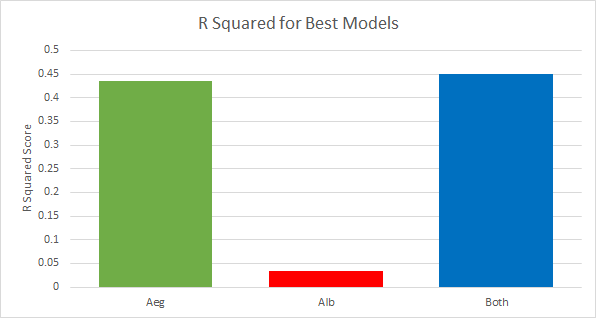









If there was more time to pursue this project, the performance of the second best models could be considered. In addition, Support Vector Machine regression, Ridge regression, and Elastic-Net regression are other models that could be applied to the dataset as well. The application of other ensemble methods such as Gradient Boosting regression to the data set is an option that could be explored as well. 

## References
- Fraj, M. B. (2017, December 21). *In Depth: Parameter tuning for Random Forest.* All Things AI. https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

- Moody, J. (2017, December 21). *What does RMSE really mean?* Towards Data Science. https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e

- Myer, M. H., Fizer, C. M., McPherson, K. R., Neale, A. C., Pilant, A. N., Rodriguez, A., ... & Johnston, J. M. (2019). Mapping Aedes aegypti (Diptera: Culicidae) and Aedes albopictus Vector Mosquito Distribution in Brownsville, TX. *Journal of medical entomology, 57(1)*, 231-240.

- Scikit-learn: Machine Learning in Python. (2020) *1.1. Linear Models.* https://scikit-learn.org/stable/modules/linear_model.html#lasso